## 1. Попробуйте изменить параметры нейронной сети, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) или любым любимым временным рядом так, чтобы улучшить её точность. Приложите анализ

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import datetime

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
# %load_ext tensorboard

In [4]:
# %reload_ext tensorboard

Читаем данные из файла со значениями (потребление энергии дневные отсчеты)

In [5]:
df = pd.read_csv('airline-passengers.csv')
df.index = df.Month
df.reset_index(drop=True, inplace=True)

Данные о потреблении энергии+ индексы (дата)

In [6]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


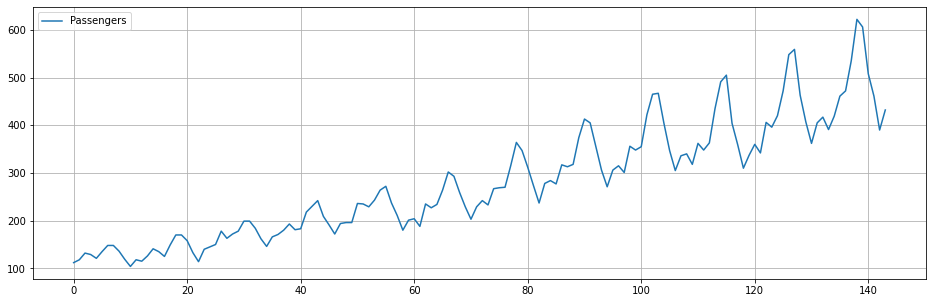

In [7]:
df.plot( figsize = (16,5))
plt.grid('On')
plt.show()

In [8]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [9]:
df_train = df.iloc[:100, :]
df_train.sort_values(by="Month", ascending=True).head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
df_train['Month'] = pd.to_datetime(df_train.Month)

df_train.Month = df_train.Month.dt.month

In [11]:
df_train.head()

,Month,Passengers
0,1,112
1,2,118
2,3,132
3,4,129
4,5,121


In [12]:
X_train, y_train = df_train, df_train.Passengers

In [13]:
xLEN = 4
batch_size = 5
epochs = 10

train_data = keras.preprocessing.timeseries_dataset_from_array(
    X_train.iloc[:-xLEN,:],
    y_train[xLEN:],
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size
)

In [14]:
for batch in train_data.take(2):
    inputs, targets = batch

In [15]:
targets[0]

<tf.Tensor: shape=(), dtype=int64, numpy=119>

In [16]:
inputs[1,:,:]

<tf.Tensor: shape=(4, 2), dtype=int64, numpy=
array([[  7, 148],
       [  8, 148],
       [  9, 136],
       [ 10, 119]])>

### Тестовая выборка

In [17]:
df_test = df_train = df.iloc[100:, :]
df_test.head()

,Month,Passengers
100,1957-05,355
101,1957-06,422
102,1957-07,465
103,1957-08,467
104,1957-09,404


In [18]:
df_test['Month'] = pd.to_datetime(df_test.Month)

df_test.Month = df_test.Month.dt.month

In [19]:
X_test, y_test = df_test, df_test.Passengers

In [20]:
X_test.head()

,Month,Passengers
100,5,355
101,6,422
102,7,465
103,8,467
104,9,404


### Подготовим данные для обучения и валидации

In [21]:
data = X_train.copy() # берем все что есть

In [22]:
data.shape[1]

2

In [23]:
data.head()

,Month,Passengers
0,1,112
1,2,118
2,3,132
3,4,129
4,5,121


Делаем нормализацию

In [24]:
val_split = 20
scaler = StandardScaler()
data_v = scaler.fit(data[:val_split])
 
data_f = pd.DataFrame(scaler.transform(data))

Создаем данные для обучения

In [25]:
# список признаков, по которым будем учить
channelIndexes = [0, 1]

# длина теста
valLen = 20

# отступ тестов от тренировок
bias = 3

# вычисляем точку разделения ряда на тесты и тренировку
train_split = data_f.shape[0] - valLen - bias
train_split
# # делим
train_data = data_f.iloc[0 : train_split ,channelIndexes]
val_data = data_f.iloc[train_split+bias:,channelIndexes]

In [26]:
train_data.head(7)

,0,1
0,-1.470906,-1.181840
1,-1.157947,-0.836777
2,-0.844989,-0.031631
3,-0.532030,-0.204162
4,-0.219071,-0.664246
5,0.093888,0.140901
6,0.406846,0.888537


In [27]:
val_data.head(3)

,0,1
80,1.032764,10.320251
81,1.345723,8.134854
82,1.658681,6.006967


Формируем параметры для генерации выборки

In [28]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLEN
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
# batch_size = 5
epochs = 10


Выделяем части на обучение и проверку

In [29]:
Chanel_numb = len(channelIndexes)

start = xLEN + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLEN+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLEN-1:,1].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLEN / step)


x_end = len(val_data) - xLEN - future 

label_start = len(train_data)+bias+xLEN + future +1

xVal_df = val_data.iloc[:-future-xLEN+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLEN-1:,1].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [30]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(73, 2)
(73,)
(16, 2)
(16,)


Посмотрим на них

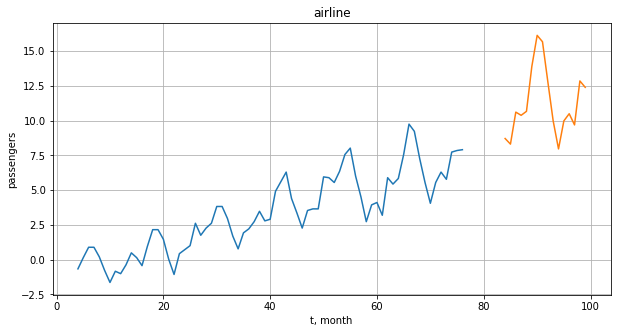

In [31]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLEN:yTrain.shape[0]+xLEN],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+bias+future+2*xLEN-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, month')
plt.ylabel('passengers')
plt.title('airline')
plt.show()

Используем механизм формирования пакетов для обучения

In [32]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLEN,
    sampling_rate=1,
    batch_size=batch_size,
)


In [33]:
for batch in dataset_val.take(2):
    inputs, targets = batch

In [34]:
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (5, 4, 2)
Target shape: (5,)


In [35]:
inputs[1,:,:]

<tf.Tensor: shape=(4, 2), dtype=float64, numpy=
array([[-0.84498868, 10.60780356],
       [-0.53202991, 10.37776174],
       [-0.21907114, 10.66531401],
       [ 0.09388763, 13.88589953]])>

In [36]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=13.885899534145489>

In [40]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

**сеть:  LSTM слои+Conv1D +Dense слой.**

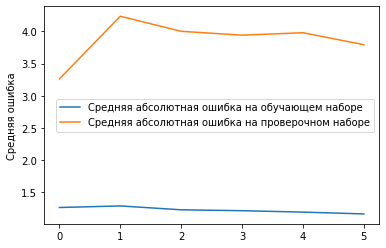

In [41]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True"))
model.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())
model.add(Dense(3, activation="linear"))

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback], verbose=0)


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [42]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

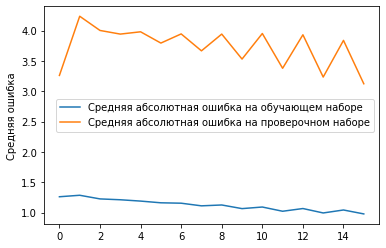

In [43]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback], verbose=0)

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [45]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

In [46]:
yVal.shape, predVal.shape

((16,), (13,))

Валидация:

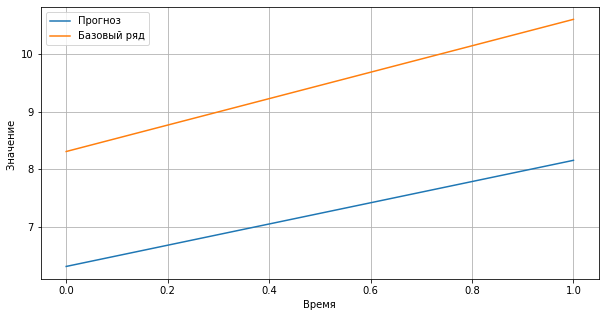

In [47]:
start = 1
step = 2
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Тренировочные даннные:

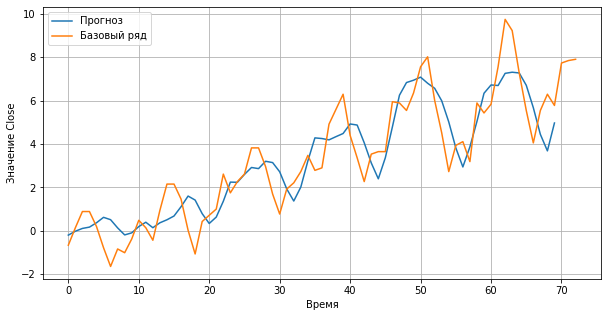

In [48]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Проверяем качество модели:
- оценим по лаговой корреляции рядов a, b;
- если наибольшая корреляция с лагом 0, то отлично;
- есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).


In [49]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [50]:
start = 1
step = 3

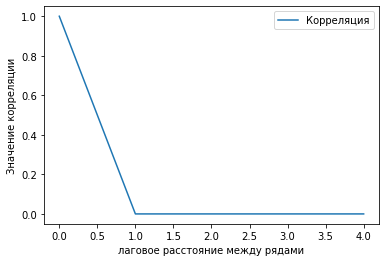

In [51]:
corr = []
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

In [52]:
corr

[1.0000000000000113, 0, 0, 0, 0]

### Если честно, то с рядами мало, что понятно..

## 2. Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения

In [73]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku 
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers

Разбор текста - Токенизация

In [56]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(num_words=10000)
data = open('alice_in_wonderland.txt').read()
#Читаем текст
corpus = data.lower().split("\n")

In [57]:
corpus[:10]

['project gutenberg’s alice’s adventures in wonderland, by lewis carroll',
 '',
 'this ebook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  you may copy it, give it away or',
 're-use it under the terms of the project gutenberg license included',
 'with this ebook or online at www.gutenberg.org',
 '',
 '',
 'title: alice’s adventures in wonderland',
 '']

Исполним токенизацию и кодирование

In [62]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [63]:
token_list

[3397, 4, 367, 1307, 3398, 4, 278, 38, 497, 622]

In [65]:
tokenizer.index_word[30]

'but'

In [66]:
tokenizer.word_index['love']

1065

In [67]:
input_sequences[11:15,:]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         22, 444,  31,  24,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22,
        444,  31,  24,   1, 150],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,
         31,  24,   1, 150,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 444,  31,
         24,   1, 150,   6, 707]], dtype=int32)

In [68]:
label.shape

(28231, 3399)

Создаем сеть

In [69]:
callback = EarlyStopping(monitor='val_loss', patience=10) # создаем обратный вызов - calback - тут "Ранний останов"

In [74]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
#model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(128))
model.add(Dropout( 0.2))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 17, 256)           870144    
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1699)              219171    
_________________________________________________________________
dense_7 (Dense)              (None, 3399)              5778300   
Total params: 7,064,735
Trainable params: 7,064,735
Non-trainable params: 0
_________________________________________________________________
None


In [76]:
history = model.fit(predictors,
                    label,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[callback],
                    verbose=0)

Epoch 1/10
706/706 [==============================] - 60s 85ms/step - loss: 4.9721 - accuracy: 0.1420 - val_loss: 7.7403 - val_accuracy: 0.1078
Epoch 2/10
706/706 [==============================] - 64s 90ms/step - loss: 4.7901 - accuracy: 0.1622 - val_loss: 7.9725 - val_accuracy: 0.1034
Epoch 3/10
706/706 [==============================] - 58s 82ms/step - loss: 4.6368 - accuracy: 0.1754 - val_loss: 8.0393 - val_accuracy: 0.1068
Epoch 4/10
706/706 [==============================] - 56s 79ms/step - loss: 4.4938 - accuracy: 0.1882 - val_loss: 8.3600 - val_accuracy: 0.1091
Epoch 5/10
706/706 [==============================] - 44s 62ms/step - loss: 4.3661 - accuracy: 0.1993 - val_loss: 8.5767 - val_accuracy: 0.1009
Epoch 6/10
706/706 [==============================] - 44s 62ms/step - loss: 4.2395 - accuracy: 0.2088 - val_loss: 8.6649 - val_accuracy: 0.1172
Epoch 7/10
706/706 [==============================] - 44s 62ms/step - loss: 4.1218 - accuracy: 0.2173 - val_loss: 8.8242 - val_accuracy:

Тест


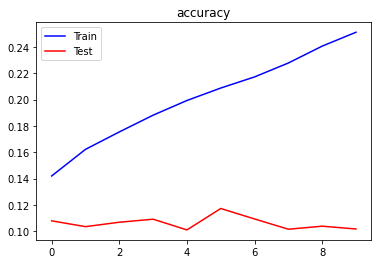

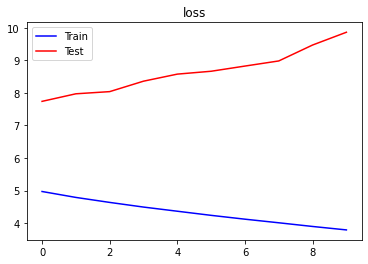

In [77]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Строим тест генератора

In [78]:
# начальная строка
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
#seed_text = "She is my girl, I see in"
next_words = 15
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
    predicted = model.predict_classes(token_list, verbose=0)
  # 
    output_word = ""
    # добавим новое слово в последовательность
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

[360, 69, 80, 107, 841]
[360, 69, 80, 107, 841, 15]
[360, 69, 80, 107, 841, 15, 85]
[360, 69, 80, 107, 841, 15, 85, 46]
[360, 69, 80, 107, 841, 15, 85, 46, 2]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1, 81]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1, 81, 82]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1, 81, 82, 79]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1, 81, 82, 79, 41]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1, 81, 82, 79, 41, 58]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1, 81, 82, 79, 41, 58, 25]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1, 81, 82, 79, 41, 58, 25, 5]
[360, 69, 80, 107, 841, 15, 85, 46, 2, 9, 1, 81, 82, 79, 41, 58, 25, 5, 32]
Help me Obi Wan Kenobi, you're my only hope i don’t know ’ said the mock turtle ‘and what would be a little thing


Посмотрим на предсказание через вероятные ответы (не олно слово имеет большую вероятность)

In [79]:
y_p=model.predict(token_list)

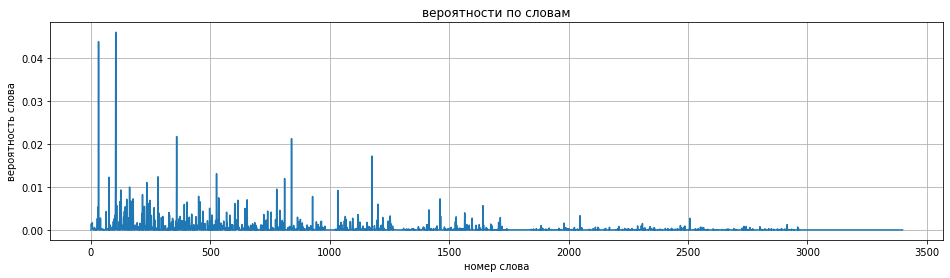

In [80]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [81]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([ 32, 104])

In [82]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

little  :  0.04373589
thing  :  0.04591841


In [83]:
seed_text = "She is my girl, I see in"
next_words = 15
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  print(token_list)
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p=model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

[7, 31, 80, 840, 15, 65, 10]
[7, 31, 80, 840, 15, 65, 10, 5]
[7, 31, 80, 840, 15, 65, 10, 5, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2, 9]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2, 9, 1]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2, 9, 1, 81]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2, 9, 1, 81, 82]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2, 9, 1, 81, 82, 79]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2, 9, 1, 81, 82, 79, 8]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2, 9, 1, 81, 82, 79, 8, 13]
[7, 31, 80, 840, 15, 65, 10, 5, 32, 32, 32, 104, 2, 9, 1, 81, 82, 79, 8, 13, 47]
She is my girl, I see in a little little little thing ’ said the mock turtle ‘and it was no use


### Даже получилось что-то вменяемое.
### Построим более сложную модель.

In [84]:
model2 = Sequential()
model2.add(Embedding(total_words, 256, input_length=max_sequence_len-1))

model2.add(LSTM(64, return_sequences="True"))
model2.add(LSTM(64, return_sequences="True"))
model2.add(Dropout( 0.2))
model2.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model2.add(Dense(total_words, activation='softmax'))
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model2.summary())

# model2.add(Conv1D(64, 3, activation="linear"))
#model.add(Conv1D(64, 1, activation="linear"))
# model2.add(Flatten())                        


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 17, 256)           870144    
_________________________________________________________________
lstm_8 (LSTM)                (None, 17, 64)            82176     
_________________________________________________________________
lstm_9 (LSTM)                (None, 17, 64)            33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 64)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 17, 1699)          110435    
_________________________________________________________________
dense_9 (Dense)              (None, 17, 3399)          5778300   
Total params: 6,874,079
Trainable params: 6,874,079
Non-trainable params: 0
____________________________________________

In [85]:
history = model.fit(predictors,
                    label,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[callback],
                    verbose=0)

Тест


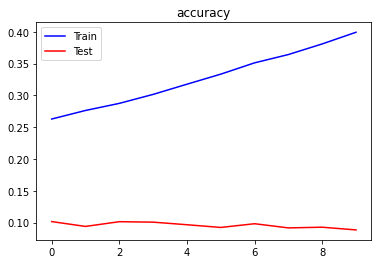

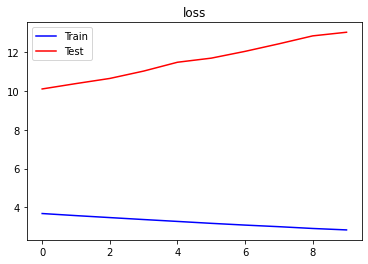

In [86]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

Строим тест генератора

In [87]:
# начальная строка
seed_text = "She is my girl, I see in"
next_words = 15
# строим последовательность + новое предсказание  
for _ in range(next_words):
  # текущая последовательность (токенизация и дополнение)
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  # делаем предсказание (сразу как индекс класса - у нас 1 из 3211)
    predicted = model.predict_classes(token_list, verbose=0)
  # 
    output_word = ""
    # добавим новое слово в последовательность
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

[7, 31, 80, 840, 15, 65, 10]
[7, 31, 80, 840, 15, 65, 10, 14]
[7, 31, 80, 840, 15, 65, 10, 14, 2]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53, 33]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53, 33, 85]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53, 33, 85, 46]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53, 33, 85, 46, 41]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53, 33, 85, 46, 41, 1438]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53, 33, 85, 46, 41, 1438, 521]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53, 33, 85, 46, 41, 1438, 521, 190]
[7, 31, 80, 840, 15, 65, 10, 14, 2, 7, 9, 4, 53, 33, 85, 46, 41, 1438, 521, 190, 100]
She is my girl, I see in that ’ she said to herself ‘i don’t know what “it” means than now ’


Посмотрим на предсказание через вероятные ответы (не олно слово имеет большую вероятность)

In [88]:
y_p=model.predict(token_list)

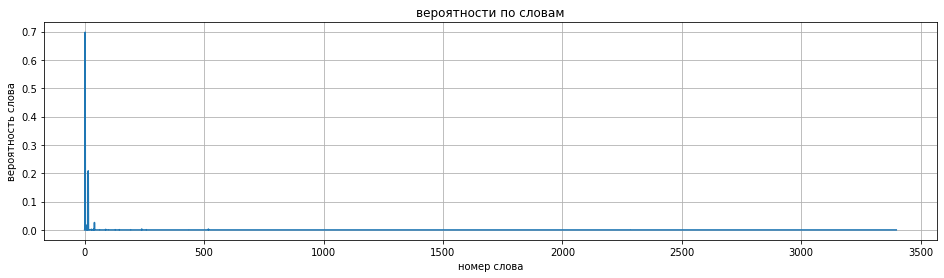

In [89]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [90]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([ 2, 15])

In [91]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

’  :  0.6975132
i  :  0.20839468


### С текстом понимания побольше. Но не понятно, как улучшить сеть, потому что все зависит от того, что хочется получить. По-моему, здесь вышло даже не так уж плохо :)